# This notebook goes with Lesson 10, section 12 of the Tensorflow 2.0 course on Udacity. It is an improved text generation model.

In [1]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
import numpy as np
import pandas as pd

In [2]:
!wget --no-check-certificate \
    https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 \
    -O /tmp/songdata.csv

--2020-12-13 22:48:28--  https://drive.google.com/uc?id=1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving drive.google.com (drive.google.com)... 172.217.6.46, 2607:f8b0:4005:809::200e
Connecting to drive.google.com (drive.google.com)|172.217.6.46|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cl4f5defij7b54d6dundck9ecam45o2g/1607899650000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8 [following]
--2020-12-13 22:48:30--  https://doc-04-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/cl4f5defij7b54d6dundck9ecam45o2g/1607899650000/11118900490791463723/*/1LiJFZd41ofrWoBtW-pMYsfz1w8Ny0Bj8
Resolving doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)... 216.58.194.161, 2607:f8b0:4005:804::2001
Connecting to doc-04-ak-docs.googleusercontent.com (doc-04-ak-docs.googleusercontent.com)|216.58.194.161|:443

## Preprocessing

In [13]:
def tokenize_corpus(corpus, num_words=-1):
    if num_words > -1:
        tokenizer = Tokenizer(num_words)
    else:
        tokenizer = Tokenizer
    tokenizer.fit_on_texts(corpus)
    return tokenizer

def create_lyrics_corpus(dataset, field):
    dataset[field] = dataset[field].str.replace('[{}]'.format(string.punctuation), "")
    dataset[field] = dataset[field].str.lower()
    lyrics = dataset[field].str.cat()
    corpus = lyrics.split('\n')
    for l in range(len(corpus)):
        corpus[l] = corpus[l].rstrip()
    corpus = [l for l in corpus if l != '']
    
    return corpus


In [14]:
dataset = pd.read_csv('/tmp/songdata.csv', dtype=str)[:250]

corpus = create_lyrics_corpus(dataset, 'text')

tokenizer = tokenize_corpus(corpus, num_words=2000)

total_words = tokenizer.num_words

print(total_words)

2000


## Create sequences and labels

In [15]:
sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        sequences.append(n_gram_sequence)

In [17]:
max_sequence_len = max([len(seq) for seq in sequences])
sequences = np.array(pad_sequences(sequences, maxlen=max_sequence_len,
                                  padding='pre'))

input_sequences, labels = sequences[:,:-1], sequences[:,-1]
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Train the Model

In [34]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(total_words, 64, input_length = max_sequence_len-1),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(total_words, activation='softmax')
])
model.compile(optimizer='adam',
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
history = model.fit(input_sequences, one_hot_labels, epochs=500, verbose=1)

Epoch 1/500
1480/1480 [==============================] - 18s 12ms/step - loss: 5.9808 - accuracy: 0.0465
Epoch 2/500
1480/1480 [==============================] - 18s 12ms/step - loss: 5.6967 - accuracy: 0.0502
Epoch 3/500
1480/1480 [==============================] - 17s 12ms/step - loss: 5.5284 - accuracy: 0.0618
Epoch 4/500
1480/1480 [==============================] - 17s 12ms/step - loss: 5.3483 - accuracy: 0.0838
Epoch 5/500
1480/1480 [==============================] - 17s 12ms/step - loss: 5.1828 - accuracy: 0.1070
Epoch 6/500
1480/1480 [==============================] - 17s 12ms/step - loss: 5.0485 - accuracy: 0.1215
Epoch 7/500
1480/1480 [==============================] - 17s 12ms/step - loss: 4.9176 - accuracy: 0.1354
Epoch 8/500
1480/1480 [==============================] - 17s 12ms/step - loss: 4.7694 - accuracy: 0.1497
Epoch 9/500
1480/1480 [==============================] - 17s 12ms/step - loss: 4.6323 - accuracy: 0.1628
Epoch 10/500
1480/1480 [==============================]

### Check training graph

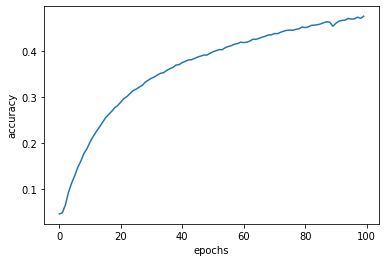

In [26]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.xlabel('epochs')
    plt.ylabel(string)
    plt.show()
    
plot_graphs(history, 'accuracy');

## Generate Lyrics

In [29]:
seed_text = 'im feeling chills'
next_words = 100

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = np.argmax(model.predict(token_list), axis=-1)
    output_word = ''
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word

print(seed_text)

im feeling chills a while he was a sunny day outside the action help her clown bluest ways worn secrets memory beat beat played imagine smiles survive truth thrill smoke bang looks football business ahha ahha steady stare cried walks brother rattlesnake uh uh summer distance truth complain scars happen save memory teaser smiles survive truth complain jungle why i have that i be together for you now know its all there tonight were all night now had to see me bound dreamed to fans im happens time survive imagine lately survive survive survive up looks passion window football old goodbye stayed out


## Randomize Generated Lyrics, proportion to predicted probability

In [32]:
def predict_lyrics(seed_text, next_words):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len, padding='pre')
        predicted_probs = model.predict(token_list)[0]
        predicted = np.random.choice([x for x in range(len(predicted_probs))],
                                    p=predicted_probs)
        output_word = ""
        for word, index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        seed_text += " " + output_word
        return seed_text

In [33]:
predict_lyrics(seed_text, next_words)

'im feeling chills a while he was a sunny day outside the action help her clown bluest ways worn secrets memory beat beat played imagine smiles survive truth thrill smoke bang looks football business ahha ahha steady stare cried walks brother rattlesnake uh uh summer distance truth complain scars happen save memory teaser smiles survive truth complain jungle why i have that i be together for you now know its all there tonight were all night now had to see me bound dreamed to fans im happens time survive imagine lately survive survive survive up looks passion window football old goodbye stayed out your'